In [1]:
"""
1. 네이버증권 투자의견 분석(업종별 비교)
"""
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams, style
style.use('ggplot')
matplotlib.rc('font', family='Malgun Gothic')

from lxml import html, cssselect
import requests

In [ ]:
'''
데이터 크롤링 및 가공 과정
==> 맨 하단의 피클 데이터 가져올 것
'''

''' 
0. 코스피200코드표 읽기 ==> 네이버에서 한글코드명 붙이기
'''
kospi = pd.read_csv('C:\\Users\\user\kospi_20170502.crm', sep='\t', header=None)
kospi.columns = ['code', 'stock','industry']
kospi['group1'] = 'KOSPI'

kosdaq = pd.read_csv('C:\\Users\\user\kosdaq_20170502.crm', sep='\t', header=None)
kosdaq.columns = ['code', 'stock','industry']
kosdaq['group1'] = 'KOSDAQ'

stock_info = pd.concat([kospi, kosdaq], axis=0, ignore_index=True)

# 피클로 저장
stock_info.to_pickle('stock_info_pickle')
# stock_info = read.pickle('stock_info_pickle')



""" url -> elem 객체 생성 함수 """
def url_elem(u):
    url = u
    resp = requests.get(url)
    return html.fromstring(resp.text)



''' 
네이버증권 한글 업종명 붙이기 : (거래소 업종명 보다 상세함)
'''
industry_n = []
for stock in stock_info['code']:
    url = 'http://finance.naver.com/item/main.nhn?code=' + stock[:6]    
    #content > div.section.trade_compare > h4 > em > a
    elem = url_elem(url) 
    if elem.cssselect('h4 em a') == []:  # 미분류 처리
        industry_n.append('미분류')
    else:
        for i in elem.cssselect('h4 em a'):    
            if i.text_content() != '':   
                industry_n.append(i.text_content().strip())
            

'''
네이버증권 투자의견
   => 1792개 종목 중 320개만 유효값
'''
consensus = []
for stock in stock_info['code']:
    url = 'http://finance.naver.com/item/main.nhn?code=' + stock[:6]
    # tab_con1 > div:nth-child(4) > table > tbody > tr:nth-child(1) > td > span.f_up > em
    # http://finance.naver.com/item/main.nhn?code=000230 일동홀딩스 -> 투자의견 없음
    # tab_con1 > div:nth-child(4) > table > tbody > tr:nth-child(1) > td > span:nth-child(1) > em 
    elem = url_elem(url)    
    if elem.cssselect('td span.f_up em') == []:  # 투자의견이 없는 종목
        consensus.append('')
    else:
        for i in elem.cssselect('td span.f_up em'):  
            consensus.append(i.text_content().strip())
# (pd.Series(consensus) != '').sum()   => 유효값 320개 



''' 
최종 데이터 생성
'''
cons = pd.DataFrame({'consensus':consensus})
inds = pd.DataFrame({'industry_n':industry_n})
stock_info_consensus = pd.concat([stock_info, cons, inds], axis=1)


# 피클로 저장
stock_info_consensus.to_pickle('stock_info_consensus_pickle')

In [7]:
stock_info_consensus = pd.read_pickle('stock_info_consensus_pickle')
stock_info_consensus.head()

,code,stock,industry,group1,consensus,industry_n
0,030720.KS,동원수산,어업,KOSPI,,식품
1,007160.KS,사조산업,어업,KOSPI,,식품
2,006040.KS,동원산업,어업,KOSPI,4.17,식품
3,004970.KS,신라교역,어업,KOSPI,,식품
4,006090.KS,사조오양,어업,KOSPI,,식품


In [10]:
# 결측값(=='') 제외 후 => 수치형 변경 => 업종별 평균 내기/차트구성
df_sub = stock_info_consensus[ stock_info_consensus.consensus != '' ]
df_sub['consensus'] = df_sub['consensus'].apply(lambda x: float(x))
# df_sub.pivot_table('consensus', aggfunc='mean', index=['industry'])   # aggfunc='count'
print(df_sub['consensus'].describe())


# 투자의견 상위순으로 정렬
df_sub.sort_values(by='consensus', ascending=False, inplace=True)
df_sub.index = np.arange(0, len(df_sub))  # 인덱스 새롭게 주기(중요~!!!!!!)
df_sub.head(10)

count    320.000000
mean       3.944000
std        0.160357
min        3.500000
25%        3.857500
50%        4.000000
75%        4.000000
max        4.330000
Name: consensus, dtype: float64


c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,code,stock,industry,group1,consensus,industry_n
0,222800.KS,심텍,IT H/W,KOSDAQ,4.33,전자장비와기기
1,003690.KS,코리안리,금융업,KOSPI,4.33,손해보험
2,052330.KS,코텍,IT H/W,KOSDAQ,4.33,전자장비와기기
3,192400.KS,쿠쿠전자,전기전자,KOSPI,4.33,가정용기기와용품
4,004000.KS,롯데정밀화학,화학,KOSPI,4.33,화학
5,084010.KS,대한제강,철강금속,KOSPI,4.33,철강
6,241710.KS,코스메카코리아,화학,KOSDAQ,4.25,화장품
7,104700.KS,한국철강,철강금속,KOSPI,4.25,철강
8,228850.KS,레이언스,의료·정밀기기,KOSDAQ,4.25,건강관리장비와용품
9,00781K.KS,코리아써키트2우B,전기전자,KOSPI,4.25,전자장비와기기


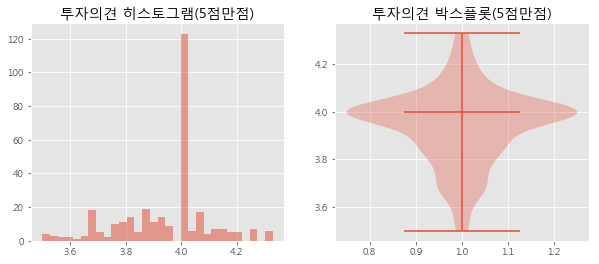

In [9]:
# 투자의견 히스토그램
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].hist(df_sub['consensus'], bins=30, alpha=0.5)
ax[0].set_title('투자의견 히스토그램(5점만점)')
# ax[1].boxplot(df_sub['consensus'])  
ax[1].violinplot(df_sub['consensus'], showmeans=False, showmedians=True)
ax[1].set_title('투자의견 박스플롯(5점만점)')
plt.show()

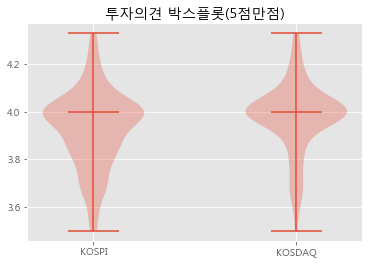

In [11]:
# 코스피, 코스닥 히스토그램
lst1, lst2 = [], []

# for group_code in df_sub['group1']:
for i in range(len(df_sub)):
    if df_sub.ix[i,'group1'] == 'KOSPI':
        lst1.append(df_sub.ix[i,'consensus'])
    else:
        lst2.append(df_sub.ix[i,'consensus'])

lst_all = [lst1, lst2]

fig, ax = plt.subplots()
ax.violinplot(lst_all, showmeans=False, showmedians=True)
ax.set_title('투자의견 박스플롯(5점만점)')
plt.setp(ax, xticks=[y+1 for y in range(len(lst_all))],
         xticklabels=['KOSPI', 'KOSDAQ'])
plt.show()

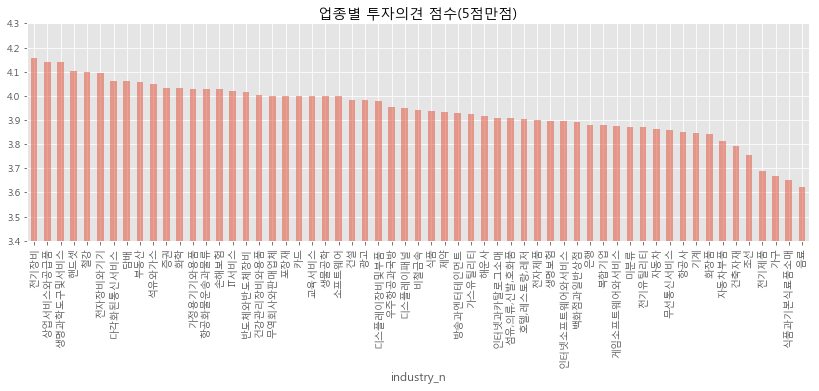

In [15]:
# 업종별 점수 분포 => # 1건인 경우도 포함됨에 유의
df_sub.groupby('industry_n')['consensus'].mean().sort_values(ascending=False)\
    .plot(kind='bar', figsize=(14,4), ylim=(3.4, 4.3), 
          alpha=0.5, title='업종별 투자의견 점수(5점만점)')
plt.show()